#### 이번에는 Ray를 활용하면서 visualization하는 방법에 대해 알아보겠습니다. <br>

    1. Actor는 현재 노트북이 열린 pid와는 다른 pid에서 실행이 되므로, Actor안에서 노트북으로 바로 출력하기 어렵다.
    2. 따라서 Actor는 자신의 score 데이터를 다른 곳에 넘겨준다.
    3. 2번에서 넘겨준 데이터를 learner에서 plot한다(learner는 쥬피터 노트북 pid에서 실행이 되므로). 

In [ ]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !pip install ray

In [1]:
import ray
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
ray.init() 

2021-01-29 15:24:02,630	INFO services.py:1173 -- View the Ray dashboard at http://127.0.0.1:8267


{'node_ip_address': '192.168.0.61',
 'raylet_ip_address': '192.168.0.61',
 'redis_address': '192.168.0.61:31974',
 'object_store_address': '/tmp/ray/session_2021-01-29_15-24-01_838388_96450/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-01-29_15-24-01_838388_96450/sockets/raylet',
 'webui_url': '127.0.0.1:8267',
 'session_dir': '/tmp/ray/session_2021-01-29_15-24-01_838388_96450',
 'metrics_export_port': 62855,
 'node_id': 'c8ffba8ef3714b35081d253bf27d534cec871d36'}

In [3]:
@ray.remote 
class Plot_inline:  
    def __init__(self): 
        # actor의 개수가 여러개 있을 때 동적으로 dictionary의 key를 생성할 수 있도록 defalutdict를 활용
        self.score_dict = defaultdict(list) 
    
    def store_actor_data(self, actor_idx, score): 
        ''' Actor의 data를 저장합니다 '''
        self.score_dict[actor_idx].append(score) 
        
    def store_learner_data(self, score): 
        ''' Learner의 data를 저장합니다 '''
        self.score_dict['learner'].append(score) 

    def get_status(self): 
        ''' 쌓인 data를 return합니다 '''
        return self.score_dict 

In [4]:
@ray.remote
class Actor:
    def __init__(self, num_actors, plot_util):
        self.plot_util = plot_util
        self.num_actors = num_actors
        
    def gen_data(self):
        ''' 임의의 데이터를 plot_util 객체에 넘겨줍니다. '''
        for _ in range(100):
            score = np.random.randn() 
            actor_idx = np.random.randint(1, self.num_actors+1)
            self.plot_util.store_actor_data.remote(actor_idx, score) 
        return "Done."  # done은 안보내줘도 됩니다. 그냥 실행 완료 signal을 보내주도록 쓴 것 입니다.

In [5]:
class Learner:
    def __init__(self, plot_util, num_actors): 
        self.num_actors = num_actors 
        self.plot_util = plot_util 
        self.plot_util.get_status.remote()

    def train(self):
        ''' 임의의 데이터를 plot_util에 넘깁니다 '''
        for _ in range(30): 
            score = np.random.randn()  
            self.plot_util.store_learner_data.remote(score) 
        print("Done.")

    def plot_inline(self):  
        ''' 쥬피터 노트북에 plot해주는 함수 '''
        score_dict = ray.get(self.plot_util.get_status.remote()) 
        clear_output(True)
        plt.figure(facecolor='w', figsize=(25,25)) 
        for idx in range(1, len(score_dict)):
            i,j = (idx-1)//5, (idx-1)%5 
            plt.subplot2grid((5,5), (i,j)) 
            plt.plot(score_dict[idx]) 
            plt.title(f"Score of Actor {idx}")
        if (j+1)%5==0:
            plt.subplot2grid((5,5), (i+1,0)) 
        else:
            plt.subplot2grid((5,5), (i,j+1)) 
        plt.plot(score_dict['learner']) 
        plt.title("Score of Learner") 
        plt.show() 

In [6]:
num_actors = 10

plot_util = Plot_inline.remote() 
actor = Actor.remote(num_actors, plot_util) 

In [7]:
print(ray.get(actor.gen_data.remote())) 

Done.


In [8]:
learner = Learner(plot_util, num_actors)  

In [9]:
learner.train()  

Done.


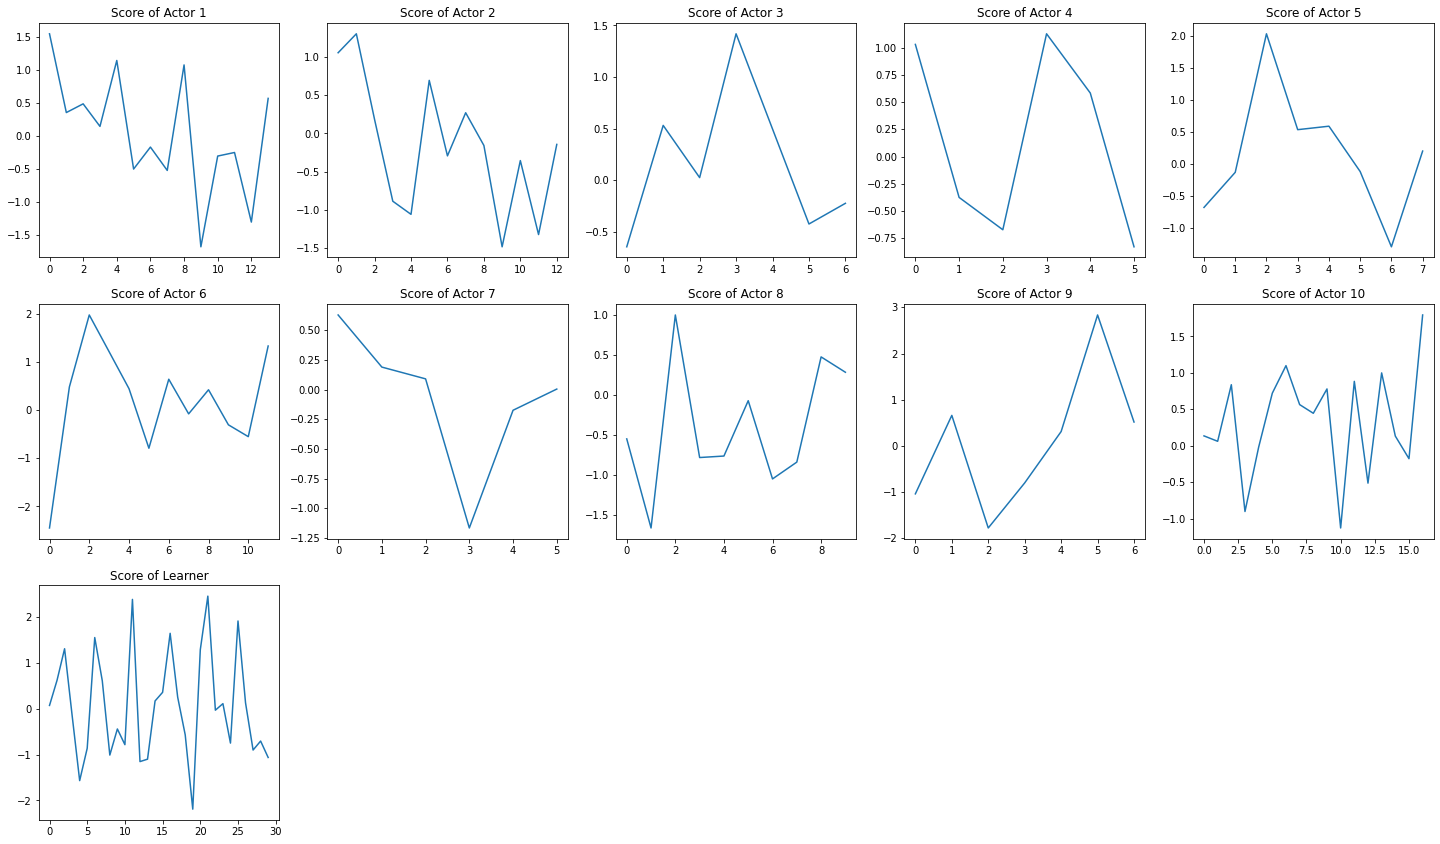

In [10]:
learner.plot_inline() 